# How to plot any radar data

**_Step 1:_ Import necessary libraries**

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

**_Step 2:_ Read Data**

In [2]:
ds = xr.open_dataset('../imd_mum/polar_MUM150615000342.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:                (time: 3599, range: 800, sweep: 10)
Coordinates:
  * time                   (time) datetime64[ns] 2015-06-15T00:03:42 ... 2015...
  * range                  (range) float64 0.0 300.0 ... 2.394e+05 2.397e+05
    azimuth                (time) float32 ...
    elevation              (time) float32 ...
Dimensions without coordinates: sweep
Data variables: (12/15)
    REF                    (time, range) float32 ...
    VEL                    (time, range) float32 ...
    WIDTH                  (time, range) float32 ...
    sweep_number           (sweep) int16 ...
    fixed_angle            (sweep) float32 ...
    sweep_start_ray_index  (sweep) int64 ...
    ...                     ...
    longitude              float32 ...
    altitude               float32 ...
    time_coverage_start    |S32 ...
    time_coverage_end      |S32 ...
    time_reference         |S32 ...
    volume_number          int32 ...
Attributes:
    instrument_name:  MUM
    Conventions:      CF/Radial
    field_names:      REF, VEL, WIDTH
    history:          created by rizvi on Syeds-MacBook-Air.local at 2021-11-...

**_Step 3:_ Retrieve required parameters**

In [4]:
rng = ds['range'] / 1000.
rng.attrs['units'] = 'km'
az = np.around(ds['azimuth']*100)/100
az.attrs['units'] = 'deg'
ele = np.around(ds['elevation']*10)/10
ele.attrs['units'] = 'deg'
ref = ds['REF']

**_Method 1:_ Using sweep start ray indices and sweep end ray indices**

In [5]:
start_idx = ds['sweep_start_ray_index'].values
end_idx = ds['sweep_end_ray_index'].values

In [6]:
start_idx,end_idx

(array([   0,  360,  720, 1080, 1440, 1800, 2160, 2520, 2880, 3240]),
 array([ 359,  719, 1079, 1439, 1799, 2159, 2519, 2879, 3239, 3599]))

In [7]:
x = rng * np.sin(np.deg2rad(az[0:359]))
y = rng * np.cos(np.deg2rad(az[0:359]))

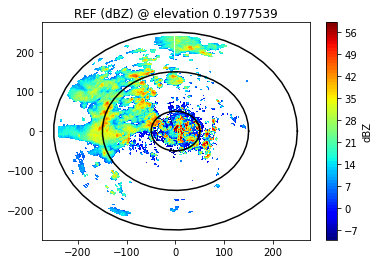

In [8]:
plt.contourf(x,y,ref[0:359].T,levels=range(-10,60),cmap='jet')
plt.colorbar(label='dBZ')
plt.title('REF (dBZ) @ elevation '+str(ds.fixed_angle[0].values))
t = np.linspace(0,2*np.pi)
for r in [50,150,250]:
    a, = plt.plot(r*np.cos(t),r*np.sin(t), color='k',label=f"${r=}$")
plt.show()

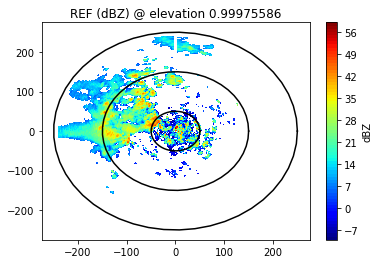

In [9]:
x = rng * np.sin(np.deg2rad(az[360:720]))
y = rng * np.cos(np.deg2rad(az[360:720]))
plt.contourf(x,y,ref[360:720].T,levels=range(-10,60),cmap='jet')
plt.colorbar(label='dBZ')
plt.title('REF (dBZ) @ elevation '+str(ds.fixed_angle[1].values))
t = np.linspace(0,2*np.pi)
for r in [50,150,250]:
    a, = plt.plot(r*np.cos(t),r*np.sin(t), color='k',label=f"${r=}$")
plt.show()

**_Method 2:_ By creating function**

In [75]:
def sweep(i):
    si = ds.sweep_start_ray_index.values
    ei = ds.sweep_end_ray_index.values
    return slice(si[i],ei[i]+1)

def radar_coords_to_cart(rng, az, ele, i,debug=False):
    theta_e = ele * np.pi / 180.0  # elevation angle in radians.
    theta_a = az[sweep(i)] * np.pi / 180.0  # azimuth angle in radians.
    R = 6371.0 * 1000.0 * 4.0 / 3.0  # effective radius of earth in meters.
    r = rng  # distances to gates in meters.
    z = (r ** 2 + R ** 2 + 2.0 * r * R * np.sin(theta_e)) ** 0.5 - R
    s = R * np.arcsin(r * np.cos(theta_e) / (R + z))  # arc length in m.
    x = s * np.sin(theta_a)
    y = s * np.cos(theta_a)
    return x, y, z

def get_z_from_radar(ds):
    """Input radar object, return z from radar (km, 2D)"""
    azimuth_1D = ds.azimuth
    elevation_1D = ds.elevation
    srange_1D = ds.range
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = radar_coords_to_cart(sr_2d/1000.0, az_2d, el_2d)
    return zz + ds.altitude['data']

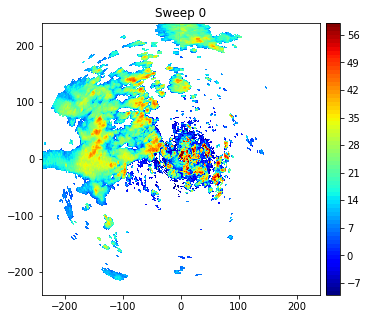

In [63]:
i = 0
ele = ds.fixed_angle[i]
x,y,z = radar_coords_to_cart(rng,az,ele,i)
plt.figure(figsize=(6,5))
plt.contourf(x,y,ds.REF[sweep(i)].T,levels=range(-10,60),cmap='jet')
plt.colorbar(pad=0.02)
plt.title('Sweep {}'.format(i))
plt.show()

**_Method 3:_ **

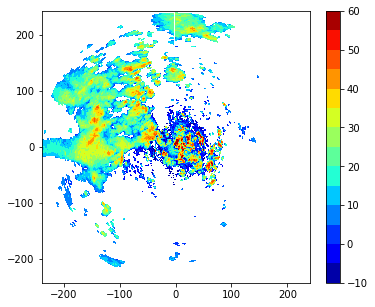

In [66]:
k1 = np.where(ds.elevation<=0.6)
e1=ds.elevation[k1]
az1=ds.azimuth[k1]
ref1=ds.REF[k1]
#convert the polar coordinates to Cartesian
x = rng * np.sin(np.deg2rad(az1))
y = rng * np.cos(np.deg2rad(az1))
ref2 = np.ma.array(ref1, mask=np.isnan(ref1))
###########################################
# Finally, we plot them up using matplotlib.
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.contourf(x,y,ref2.T,levels=np.linspace(-10,60,15),cmap='jet')
plt.colorbar()
ax.set_aspect('equal', 'datalim')